In [1]:
!pip install gym

In [2]:
!pip install gym==0.19

In [3]:
!pip install atari-py

In [4]:
!python -m atari_py.import_roms '/Users/srikanth/Downloads/Bigdata_test2_1_srikanth/Roms'

copying koolaid.bin from /Users/srikanth/Downloads/Bigdata_test2_1_srikanth/Roms/ROMS/Kool-Aid Man (Kool Aid Pitcher Man) (1983) (M Network, Stephen Tatsumi, Jane Terjung - Kool Aid) (MT4648) ~.bin to /Users/srikanth/opt/anaconda3/lib/python3.9/site-packages/atari_py/atari_roms/koolaid.bin
copying alien.bin from /Users/srikanth/Downloads/Bigdata_test2_1_srikanth/Roms/ROMS/Alien (1982) (20th Century Fox Video Games, Douglas 'Dallas North' Neubauer) (11006) ~.bin to /Users/srikanth/opt/anaconda3/lib/python3.9/site-packages/atari_py/atari_roms/alien.bin
copying demon_attack.bin from /Users/srikanth/Downloads/Bigdata_test2_1_srikanth/Roms/ROMS/Demon Attack (Death from Above) (1982) (Imagic, Rob Fulop) (720000-200, 720101-1B, 720101-1C, IA3200, IA3200C, IX-006-04) ~.bin to /Users/srikanth/opt/anaconda3/lib/python3.9/site-packages/atari_py/atari_roms/demon_attack.bin
copying crazy_climber.bin from /Users/srikanth/Downloads/Bigdata_test2_1_srikanth/Roms/ROMS/Crazy Climber (1983) (Atari - Rokl

copying tennis.bin from /Users/srikanth/Downloads/Bigdata_test2_1_srikanth/Roms/ROMS/Tennis - Le Tennis (1981) (Activision, Alan Miller) (AG-007, CAG-007) ~.bin to /Users/srikanth/opt/anaconda3/lib/python3.9/site-packages/atari_py/atari_roms/tennis.bin
copying space_invaders.bin from /Users/srikanth/Downloads/Bigdata_test2_1_srikanth/Roms/ROMS/Space Invaders (1980) (Atari, Richard Maurer - Sears) (CX2632 - 49-75153) ~.bin to /Users/srikanth/opt/anaconda3/lib/python3.9/site-packages/atari_py/atari_roms/space_invaders.bin
copying up_n_down.bin from /Users/srikanth/Downloads/Bigdata_test2_1_srikanth/Roms/ROMS/Up 'n Down (1984) (SEGA - Beck-Tech, Steve Beck, Phat Ho) (009-01) ~.bin to /Users/srikanth/opt/anaconda3/lib/python3.9/site-packages/atari_py/atari_roms/up_n_down.bin
copying galaxian.bin from /Users/srikanth/Downloads/Bigdata_test2_1_srikanth/Roms/ROMS/Galaxian (1983) (Atari - GCC, Mark Ackerman, Tom Calderwood, Glenn Parker) (CX2684) ~.bin to /Users/srikanth/opt/anaconda3/lib/pyth

copying boxing.bin from /Users/srikanth/Downloads/Bigdata_test2_1_srikanth/Roms/ROMS/Boxing - La Boxe (1980) (Activision, Bob Whitehead) (AG-002, CAG-002, AG-002-04) ~.bin to /Users/srikanth/opt/anaconda3/lib/python3.9/site-packages/atari_py/atari_roms/boxing.bin
copying fishing_derby.bin from /Users/srikanth/Downloads/Bigdata_test2_1_srikanth/Roms/ROMS/Fishing Derby (1980) (Activision, David Crane) (AG-004) ~.bin to /Users/srikanth/opt/anaconda3/lib/python3.9/site-packages/atari_py/atari_roms/fishing_derby.bin
copying kaboom.bin from /Users/srikanth/Downloads/Bigdata_test2_1_srikanth/Roms/ROMS/Kaboom! (Paddle) (1981) (Activision, Larry Kaplan, David Crane) (AG-010, CAG-010, AG-010-04) ~.bin to /Users/srikanth/opt/anaconda3/lib/python3.9/site-packages/atari_py/atari_roms/kaboom.bin
copying freeway.bin from /Users/srikanth/Downloads/Bigdata_test2_1_srikanth/Roms/ROMS/Freeway (1981) (Activision, David Crane) (AG-009, AG-009-04) ~.bin to /Users/srikanth/opt/anaconda3/lib/python3.9/site-pa

In [5]:
""" Trains an agent with (stochastic) Policy Gradients on Pong. Uses OpenAI Gym. """
import numpy as np
import pickle
import gym
import time
start_time=time.time()

# hyperparameters
H = 200 # number of hidden layer neurons
batch_size = 10 # every how many episodes to do a param update?
learning_rate = 1e-3
gamma = 0.99 # discount factor for reward
decay_rate = 0.99 # decay factor for RMSProp leaky sum of grad^2
resume = False # resume from previous checkpoint?
render = False

# model initialization
D = 80 * 80 # input dimensionality: 80x80 grid
if resume:
    model = pickle.load(open('save_200_1e-3.p', 'rb'))
else:
    model = {}
    model['W1'] = np.random.randn(H,D) / np.sqrt(D) # "Xavier" initialization
    model['W2'] = np.random.randn(H) / np.sqrt(H)

grad_buffer = { k : np.zeros_like(v) for k,v in model.items() } # update buffers that add up gradients over a batch
rmsprop_cache = { k : np.zeros_like(v) for k,v in model.items() } # rmsprop memory

def sigmoid(x):
    return 1.0 / (1.0 + np.exp(-x)) # sigmoid "squashing" function to interval [0,1]

def prepro(I):
    """ prepro 210x160x3 uint8 frame into 6400 (80x80) 1D float vector """
    I = I[35:195] # crop
    I = I[::2,::2,0] # downsample by factor of 2
    I[I == 144] = 0 # erase background (background type 1)
    I[I == 109] = 0 # erase background (background type 2)
    I[I != 0] = 1 # everything else (paddles, ball) just set to 1
    return I.astype(np.float).ravel()

def discount_rewards(r):
    """ take 1D float array of rewards and compute discounted reward """
    discounted_r = np.zeros_like(r)
    running_add = 0
    for t in reversed(range(0, r.size)):
        if r[t] != 0: running_add = 0 # reset the sum, since this was a game boundary (pong specific!)
        running_add = running_add * gamma + r[t]
        discounted_r[t] = running_add
    return discounted_r

def policy_forward(x):
    h = np.dot(model['W1'], x)
    h[h<0] = 0 # ReLU nonlinearity
    logp = np.dot(model['W2'], h)
    p = sigmoid(logp)
    return p, h # return probability of taking action 2, and hidden state

def policy_backward(eph, epdlogp):
    """ backward pass. (eph is array of intermediate hidden states) """
    dW2 = np.dot(eph.T, epdlogp).ravel()
    dh = np.outer(epdlogp, model['W2'])
    dh[eph <= 0] = 0 # backpro prelu
    dW1 = np.dot(dh.T, epx)
    return {'W1':dW1, 'W2':dW2}

env = gym.make("Pong-v0")
observation = env.reset()
prev_x = None # used in computing the difference frame
xs,hs,dlogps,drs = [],[],[],[]
running_reward = None
reward_sum = 0
episode_number = 0
while True:
    if render: env.render()

  # preprocess the observation, set input to network to be difference image
    cur_x = prepro(observation)
    x = cur_x - prev_x if prev_x is not None else np.zeros(D)
    prev_x = cur_x

  # forward the policy network and sample an action from the returned probability
    aprob, h = policy_forward(x)
    action = 2 if np.random.uniform() < aprob else 3 # roll the dice!

  # record various intermediates (needed later for backprop)
    xs.append(x) # observation
    hs.append(h) # hidden state
    y = 1 if action == 2 else 0 # a "fake label"
    dlogps.append(y - aprob) # grad that encourages the action that was taken to be taken (see http://cs231n.github.io/neural-networks-2/#losses if confused)

  # step the environment and get new measurements
    observation, reward, done, info = env.step(action)
    reward_sum += reward

    drs.append(reward) # record reward (has to be done after we call step() to get reward for previous action)

    if done: # an episode finished
        episode_number += 1

    # stack together all inputs, hidden states, action gradients, and rewards for this episode
        epx = np.vstack(xs)
        eph = np.vstack(hs)
        epdlogp = np.vstack(dlogps)
        epr = np.vstack(drs)
        xs,hs,dlogps,drs = [],[],[],[] # reset array memory

    # compute the discounted reward backwards through time
        discounted_epr = discount_rewards(epr)
    # standardize the rewards to be unit normal (helps control the gradient estimator variance)
        discounted_epr -= np.mean(discounted_epr)
        discounted_epr /= np.std(discounted_epr)

        epdlogp *= discounted_epr # modulate the gradient with advantage (PG magic happens right here.)
        grad = policy_backward(eph, epdlogp)
        for k in model: grad_buffer[k] += grad[k] # accumulate grad over batch

    # perform rmsprop parameter update every batch_size episodes
        if episode_number % batch_size == 0:
            for k,v in model.items():
                g = grad_buffer[k] # gradient
                rmsprop_cache[k] = decay_rate * rmsprop_cache[k] + (1 - decay_rate) * g**2
                model[k] += learning_rate * g / (np.sqrt(rmsprop_cache[k]) + 1e-5)
                grad_buffer[k] = np.zeros_like(v) # reset batch gradient buffer

    # boring book-keeping
        running_reward = reward_sum if running_reward is None else running_reward * 0.99 + reward_sum * 0.01
        print('resetting env. episode reward total was {}. running mean: {}'.format(reward_sum, running_reward))
        if episode_number % 100 == 0: pickle.dump(model, open('save_200_1e-3.p', 'wb'))
        reward_sum = 0
        observation = env.reset() # reset env
        prev_x = None
        if running_reward>=-19:
            break
    if reward != 0: # Pong has either +1 or -1 reward exactly when game ends.
        print ('ep {}: game finished, reward: {}'.format(episode_number, reward) + ('' if reward == -1 else ' !!!!!!!!'))
end_time=time.time()
td_model=end_time-start_time
print('Time difference for model is %s seconds:' %(td_model))

        

/var/folders/mh/b7kpn8490nd8w7l69p27clvc0000gn/T/ipykernel_10896/2241168555.py:39: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  return I.astype(np.float).ravel()


ep 0: game finished, reward: -1.0
ep 0: game finished, reward: -1.0
ep 0: game finished, reward: -1.0
ep 0: game finished, reward: -1.0
ep 0: game finished, reward: -1.0
ep 0: game finished, reward: -1.0
ep 0: game finished, reward: -1.0
ep 0: game finished, reward: 1.0 !!!!!!!!
ep 0: game finished, reward: -1.0
ep 0: game finished, reward: -1.0
ep 0: game finished, reward: -1.0
ep 0: game finished, reward: -1.0
ep 0: game finished, reward: -1.0
ep 0: game finished, reward: -1.0
ep 0: game finished, reward: -1.0
ep 0: game finished, reward: -1.0
ep 0: game finished, reward: -1.0
ep 0: game finished, reward: -1.0
ep 0: game finished, reward: -1.0
ep 0: game finished, reward: -1.0
ep 0: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -20.0
ep 1: game finished, reward: -1.0
ep 1: game finished, reward: -1.0
ep 1: game finished, reward: -1.0
ep 1: game finished, reward: -1.0
ep 1: game finished, reward: -1.0
ep 1: game finished, reward: -1.0
ep 1: g

resetting env. episode reward total was -20.0. running mean: -19.990593883462225
ep 10: game finished, reward: -1.0
ep 10: game finished, reward: -1.0
ep 10: game finished, reward: -1.0
ep 10: game finished, reward: -1.0
ep 10: game finished, reward: -1.0
ep 10: game finished, reward: -1.0
ep 10: game finished, reward: -1.0
ep 10: game finished, reward: -1.0
ep 10: game finished, reward: -1.0
ep 10: game finished, reward: -1.0
ep 10: game finished, reward: -1.0
ep 10: game finished, reward: -1.0
ep 10: game finished, reward: -1.0
ep 10: game finished, reward: -1.0
ep 10: game finished, reward: -1.0
ep 10: game finished, reward: -1.0
ep 10: game finished, reward: -1.0
ep 10: game finished, reward: -1.0
ep 10: game finished, reward: -1.0
ep 10: game finished, reward: -1.0
ep 10: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.000687944627604
ep 11: game finished, reward: -1.0
ep 11: game finished, reward: -1.0
ep 11: game finished, reward: -1.

ep 19: game finished, reward: -1.0
ep 19: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.038873804754704
ep 20: game finished, reward: -1.0
ep 20: game finished, reward: -1.0
ep 20: game finished, reward: -1.0
ep 20: game finished, reward: -1.0
ep 20: game finished, reward: -1.0
ep 20: game finished, reward: -1.0
ep 20: game finished, reward: -1.0
ep 20: game finished, reward: -1.0
ep 20: game finished, reward: -1.0
ep 20: game finished, reward: -1.0
ep 20: game finished, reward: -1.0
ep 20: game finished, reward: -1.0
ep 20: game finished, reward: -1.0
ep 20: game finished, reward: -1.0
ep 20: game finished, reward: -1.0
ep 20: game finished, reward: -1.0
ep 20: game finished, reward: -1.0
ep 20: game finished, reward: 1.0 !!!!!!!!
ep 20: game finished, reward: -1.0
ep 20: game finished, reward: -1.0
ep 20: game finished, reward: -1.0
ep 20: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -20.038485

ep 29: game finished, reward: -1.0
ep 29: game finished, reward: 1.0 !!!!!!!!
ep 29: game finished, reward: -1.0
ep 29: game finished, reward: -1.0
ep 29: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -20.092036534723906
ep 30: game finished, reward: -1.0
ep 30: game finished, reward: -1.0
ep 30: game finished, reward: -1.0
ep 30: game finished, reward: -1.0
ep 30: game finished, reward: -1.0
ep 30: game finished, reward: -1.0
ep 30: game finished, reward: -1.0
ep 30: game finished, reward: -1.0
ep 30: game finished, reward: -1.0
ep 30: game finished, reward: -1.0
ep 30: game finished, reward: -1.0
ep 30: game finished, reward: -1.0
ep 30: game finished, reward: -1.0
ep 30: game finished, reward: -1.0
ep 30: game finished, reward: -1.0
ep 30: game finished, reward: -1.0
ep 30: game finished, reward: -1.0
ep 30: game finished, reward: -1.0
ep 30: game finished, reward: -1.0
ep 30: game finished, reward: -1.0
ep 30: game finished, reward: -1.0
r

ep 39: game finished, reward: -1.0
ep 39: game finished, reward: -1.0
ep 39: game finished, reward: -1.0
ep 39: game finished, reward: -1.0
ep 39: game finished, reward: -1.0
ep 39: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.131012554649413
ep 40: game finished, reward: -1.0
ep 40: game finished, reward: -1.0
ep 40: game finished, reward: -1.0
ep 40: game finished, reward: -1.0
ep 40: game finished, reward: -1.0
ep 40: game finished, reward: -1.0
ep 40: game finished, reward: -1.0
ep 40: game finished, reward: -1.0
ep 40: game finished, reward: 1.0 !!!!!!!!
ep 40: game finished, reward: 1.0 !!!!!!!!
ep 40: game finished, reward: -1.0
ep 40: game finished, reward: -1.0
ep 40: game finished, reward: -1.0
ep 40: game finished, reward: -1.0
ep 40: game finished, reward: -1.0
ep 40: game finished, reward: -1.0
ep 40: game finished, reward: -1.0
ep 40: game finished, reward: -1.0
ep 40: game finished, reward: -1.0
ep 40: game finished, reward

ep 49: game finished, reward: -1.0
ep 49: game finished, reward: -1.0
ep 49: game finished, reward: -1.0
ep 49: game finished, reward: -1.0
ep 49: game finished, reward: -1.0
ep 49: game finished, reward: -1.0
ep 49: game finished, reward: -1.0
ep 49: game finished, reward: -1.0
ep 49: game finished, reward: -1.0
ep 49: game finished, reward: -1.0
ep 49: game finished, reward: -1.0
ep 49: game finished, reward: -1.0
ep 49: game finished, reward: -1.0
ep 49: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.13818946287955
ep 50: game finished, reward: -1.0
ep 50: game finished, reward: -1.0
ep 50: game finished, reward: -1.0
ep 50: game finished, reward: -1.0
ep 50: game finished, reward: -1.0
ep 50: game finished, reward: -1.0
ep 50: game finished, reward: -1.0
ep 50: game finished, reward: -1.0
ep 50: game finished, reward: -1.0
ep 50: game finished, reward: -1.0
ep 50: game finished, reward: -1.0
ep 50: game finished, reward: -1.0
ep 50: gam

ep 58: game finished, reward: -1.0
ep 58: game finished, reward: -1.0
ep 58: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.107797120516693
ep 59: game finished, reward: -1.0
ep 59: game finished, reward: -1.0
ep 59: game finished, reward: -1.0
ep 59: game finished, reward: -1.0
ep 59: game finished, reward: -1.0
ep 59: game finished, reward: -1.0
ep 59: game finished, reward: -1.0
ep 59: game finished, reward: -1.0
ep 59: game finished, reward: -1.0
ep 59: game finished, reward: -1.0
ep 59: game finished, reward: -1.0
ep 59: game finished, reward: -1.0
ep 59: game finished, reward: -1.0
ep 59: game finished, reward: -1.0
ep 59: game finished, reward: -1.0
ep 59: game finished, reward: -1.0
ep 59: game finished, reward: -1.0
ep 59: game finished, reward: -1.0
ep 59: game finished, reward: -1.0
ep 59: game finished, reward: -1.0
ep 59: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.11671914931153

ep 68: game finished, reward: -1.0
ep 68: game finished, reward: -1.0
ep 68: game finished, reward: -1.0
ep 68: game finished, reward: -1.0
ep 68: game finished, reward: -1.0
ep 68: game finished, reward: -1.0
ep 68: game finished, reward: -1.0
ep 68: game finished, reward: -1.0
ep 68: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.135364215037036
ep 69: game finished, reward: -1.0
ep 69: game finished, reward: -1.0
ep 69: game finished, reward: -1.0
ep 69: game finished, reward: -1.0
ep 69: game finished, reward: -1.0
ep 69: game finished, reward: -1.0
ep 69: game finished, reward: -1.0
ep 69: game finished, reward: -1.0
ep 69: game finished, reward: -1.0
ep 69: game finished, reward: -1.0
ep 69: game finished, reward: -1.0
ep 69: game finished, reward: -1.0
ep 69: game finished, reward: -1.0
ep 69: game finished, reward: -1.0
ep 69: game finished, reward: -1.0
ep 69: game finished, reward: -1.0
ep 69: game finished, reward: -1.0
ep 69: ga

ep 78: game finished, reward: -1.0
ep 78: game finished, reward: -1.0
ep 78: game finished, reward: -1.0
ep 78: game finished, reward: -1.0
ep 78: game finished, reward: -1.0
ep 78: game finished, reward: -1.0
ep 78: game finished, reward: -1.0
ep 78: game finished, reward: -1.0
ep 78: game finished, reward: -1.0
ep 78: game finished, reward: -1.0
ep 78: game finished, reward: -1.0
ep 78: game finished, reward: -1.0
resetting env. episode reward total was -19.0. running mean: -20.169025974468337
ep 79: game finished, reward: -1.0
ep 79: game finished, reward: -1.0
ep 79: game finished, reward: 1.0 !!!!!!!!
ep 79: game finished, reward: -1.0
ep 79: game finished, reward: 1.0 !!!!!!!!
ep 79: game finished, reward: -1.0
ep 79: game finished, reward: -1.0
ep 79: game finished, reward: -1.0
ep 79: game finished, reward: -1.0
ep 79: game finished, reward: -1.0
ep 79: game finished, reward: -1.0
ep 79: game finished, reward: -1.0
ep 79: game finished, reward: -1.0
ep 79: game finished, reward

ep 88: game finished, reward: -1.0
ep 88: game finished, reward: -1.0
ep 88: game finished, reward: -1.0
ep 88: game finished, reward: -1.0
ep 88: game finished, reward: -1.0
ep 88: game finished, reward: -1.0
ep 88: game finished, reward: -1.0
ep 88: game finished, reward: -1.0
ep 88: game finished, reward: -1.0
ep 88: game finished, reward: 1.0 !!!!!!!!
ep 88: game finished, reward: -1.0
ep 88: game finished, reward: -1.0
ep 88: game finished, reward: 1.0 !!!!!!!!
ep 88: game finished, reward: -1.0
ep 88: game finished, reward: -1.0
ep 88: game finished, reward: -1.0
ep 88: game finished, reward: -1.0
ep 88: game finished, reward: -1.0
ep 88: game finished, reward: -1.0
ep 88: game finished, reward: -1.0
resetting env. episode reward total was -19.0. running mean: -20.142471078969574
ep 89: game finished, reward: -1.0
ep 89: game finished, reward: -1.0
ep 89: game finished, reward: -1.0
ep 89: game finished, reward: -1.0
ep 89: game finished, reward: -1.0
ep 89: game finished, reward

ep 97: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.169645053546095
ep 98: game finished, reward: -1.0
ep 98: game finished, reward: -1.0
ep 98: game finished, reward: 1.0 !!!!!!!!
ep 98: game finished, reward: -1.0
ep 98: game finished, reward: -1.0
ep 98: game finished, reward: -1.0
ep 98: game finished, reward: -1.0
ep 98: game finished, reward: -1.0
ep 98: game finished, reward: -1.0
ep 98: game finished, reward: -1.0
ep 98: game finished, reward: -1.0
ep 98: game finished, reward: -1.0
ep 98: game finished, reward: -1.0
ep 98: game finished, reward: -1.0
ep 98: game finished, reward: -1.0
ep 98: game finished, reward: -1.0
ep 98: game finished, reward: 1.0 !!!!!!!!
ep 98: game finished, reward: -1.0
ep 98: game finished, reward: -1.0
ep 98: game finished, reward: -1.0
ep 98: game finished, reward: -1.0
ep 98: game finished, reward: -1.0
ep 98: game finished, reward: -1.0
resetting env. episode reward total was -19.0. running mean: -2

ep 107: game finished, reward: -1.0
ep 107: game finished, reward: -1.0
ep 107: game finished, reward: -1.0
ep 107: game finished, reward: -1.0
ep 107: game finished, reward: 1.0 !!!!!!!!
ep 107: game finished, reward: -1.0
ep 107: game finished, reward: -1.0
ep 107: game finished, reward: -1.0
ep 107: game finished, reward: -1.0
ep 107: game finished, reward: -1.0
ep 107: game finished, reward: -1.0
ep 107: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -20.173493822171153
ep 108: game finished, reward: -1.0
ep 108: game finished, reward: -1.0
ep 108: game finished, reward: -1.0
ep 108: game finished, reward: -1.0
ep 108: game finished, reward: -1.0
ep 108: game finished, reward: -1.0
ep 108: game finished, reward: -1.0
ep 108: game finished, reward: -1.0
ep 108: game finished, reward: -1.0
ep 108: game finished, reward: -1.0
ep 108: game finished, reward: -1.0
ep 108: game finished, reward: -1.0
ep 108: game finished, reward: -1.0
ep 108: gam

ep 116: game finished, reward: -1.0
ep 116: game finished, reward: -1.0
ep 116: game finished, reward: -1.0
ep 116: game finished, reward: -1.0
resetting env. episode reward total was -18.0. running mean: -20.13800144086436
ep 117: game finished, reward: -1.0
ep 117: game finished, reward: -1.0
ep 117: game finished, reward: -1.0
ep 117: game finished, reward: -1.0
ep 117: game finished, reward: -1.0
ep 117: game finished, reward: -1.0
ep 117: game finished, reward: -1.0
ep 117: game finished, reward: -1.0
ep 117: game finished, reward: -1.0
ep 117: game finished, reward: -1.0
ep 117: game finished, reward: -1.0
ep 117: game finished, reward: -1.0
ep 117: game finished, reward: -1.0
ep 117: game finished, reward: -1.0
ep 117: game finished, reward: -1.0
ep 117: game finished, reward: -1.0
ep 117: game finished, reward: -1.0
ep 117: game finished, reward: -1.0
ep 117: game finished, reward: -1.0
ep 117: game finished, reward: -1.0
ep 117: game finished, reward: -1.0
resetting env. episo

ep 126: game finished, reward: -1.0
ep 126: game finished, reward: -1.0
ep 126: game finished, reward: -1.0
ep 126: game finished, reward: -1.0
ep 126: game finished, reward: -1.0
ep 126: game finished, reward: -1.0
ep 126: game finished, reward: -1.0
ep 126: game finished, reward: -1.0
ep 126: game finished, reward: -1.0
ep 126: game finished, reward: -1.0
ep 126: game finished, reward: -1.0
ep 126: game finished, reward: -1.0
ep 126: game finished, reward: -1.0
ep 126: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.152783420655243
ep 127: game finished, reward: -1.0
ep 127: game finished, reward: -1.0
ep 127: game finished, reward: -1.0
ep 127: game finished, reward: -1.0
ep 127: game finished, reward: -1.0
ep 127: game finished, reward: -1.0
ep 127: game finished, reward: -1.0
ep 127: game finished, reward: -1.0
ep 127: game finished, reward: -1.0
ep 127: game finished, reward: -1.0
ep 127: game finished, reward: -1.0
ep 127: game finish

resetting env. episode reward total was -21.0. running mean: -20.159852626419045
ep 136: game finished, reward: -1.0
ep 136: game finished, reward: -1.0
ep 136: game finished, reward: -1.0
ep 136: game finished, reward: -1.0
ep 136: game finished, reward: -1.0
ep 136: game finished, reward: -1.0
ep 136: game finished, reward: -1.0
ep 136: game finished, reward: -1.0
ep 136: game finished, reward: -1.0
ep 136: game finished, reward: -1.0
ep 136: game finished, reward: -1.0
ep 136: game finished, reward: 1.0 !!!!!!!!
ep 136: game finished, reward: -1.0
ep 136: game finished, reward: -1.0
ep 136: game finished, reward: 1.0 !!!!!!!!
ep 136: game finished, reward: -1.0
ep 136: game finished, reward: -1.0
ep 136: game finished, reward: -1.0
ep 136: game finished, reward: -1.0
ep 136: game finished, reward: 1.0 !!!!!!!!
ep 136: game finished, reward: -1.0
ep 136: game finished, reward: -1.0
ep 136: game finished, reward: -1.0
ep 136: game finished, reward: -1.0
resetting env. episode reward t

ep 145: game finished, reward: -1.0
ep 145: game finished, reward: -1.0
ep 145: game finished, reward: -1.0
ep 145: game finished, reward: -1.0
ep 145: game finished, reward: -1.0
ep 145: game finished, reward: -1.0
ep 145: game finished, reward: -1.0
ep 145: game finished, reward: -1.0
ep 145: game finished, reward: -1.0
ep 145: game finished, reward: -1.0
ep 145: game finished, reward: -1.0
ep 145: game finished, reward: -1.0
ep 145: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -20.15492137365459
ep 146: game finished, reward: -1.0
ep 146: game finished, reward: -1.0
ep 146: game finished, reward: -1.0
ep 146: game finished, reward: -1.0
ep 146: game finished, reward: -1.0
ep 146: game finished, reward: -1.0
ep 146: game finished, reward: -1.0
ep 146: game finished, reward: -1.0
ep 146: game finished, reward: -1.0
ep 146: game finished, reward: -1.0
ep 146: game finished, reward: -1.0
ep 146: game finished, reward: -1.0
ep 146: game finishe

ep 154: game finished, reward: -1.0
ep 154: game finished, reward: -1.0
ep 154: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.160665408155687
ep 155: game finished, reward: -1.0
ep 155: game finished, reward: -1.0
ep 155: game finished, reward: -1.0
ep 155: game finished, reward: -1.0
ep 155: game finished, reward: -1.0
ep 155: game finished, reward: -1.0
ep 155: game finished, reward: -1.0
ep 155: game finished, reward: 1.0 !!!!!!!!
ep 155: game finished, reward: 1.0 !!!!!!!!
ep 155: game finished, reward: 1.0 !!!!!!!!
ep 155: game finished, reward: -1.0
ep 155: game finished, reward: -1.0
ep 155: game finished, reward: -1.0
ep 155: game finished, reward: -1.0
ep 155: game finished, reward: -1.0
ep 155: game finished, reward: -1.0
ep 155: game finished, reward: -1.0
ep 155: game finished, reward: -1.0
ep 155: game finished, reward: -1.0
ep 155: game finished, reward: -1.0
ep 155: game finished, reward: -1.0
ep 155: game finished, reward: 

ep 164: game finished, reward: -1.0
ep 164: game finished, reward: -1.0
ep 164: game finished, reward: -1.0
ep 164: game finished, reward: -1.0
ep 164: game finished, reward: -1.0
ep 164: game finished, reward: -1.0
ep 164: game finished, reward: -1.0
ep 164: game finished, reward: -1.0
ep 164: game finished, reward: -1.0
ep 164: game finished, reward: -1.0
ep 164: game finished, reward: -1.0
ep 164: game finished, reward: -1.0
ep 164: game finished, reward: -1.0
ep 164: game finished, reward: -1.0
ep 164: game finished, reward: -1.0
ep 164: game finished, reward: -1.0
ep 164: game finished, reward: -1.0
ep 164: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.126460997304576
ep 165: game finished, reward: -1.0
ep 165: game finished, reward: -1.0
ep 165: game finished, reward: -1.0
ep 165: game finished, reward: -1.0
ep 165: game finished, reward: -1.0
ep 165: game finished, reward: -1.0
ep 165: game finished, reward: -1.0
ep 165: game finish

ep 173: game finished, reward: -1.0
ep 173: game finished, reward: -1.0
ep 173: game finished, reward: -1.0
ep 173: game finished, reward: -1.0
ep 173: game finished, reward: -1.0
ep 173: game finished, reward: 1.0 !!!!!!!!
ep 173: game finished, reward: -1.0
ep 173: game finished, reward: -1.0
ep 173: game finished, reward: -1.0
ep 173: game finished, reward: -1.0
ep 173: game finished, reward: -1.0
ep 173: game finished, reward: -1.0
ep 173: game finished, reward: -1.0
ep 173: game finished, reward: -1.0
resetting env. episode reward total was -19.0. running mean: -20.086314303551866
ep 174: game finished, reward: -1.0
ep 174: game finished, reward: -1.0
ep 174: game finished, reward: -1.0
ep 174: game finished, reward: -1.0
ep 174: game finished, reward: -1.0
ep 174: game finished, reward: -1.0
ep 174: game finished, reward: -1.0
ep 174: game finished, reward: -1.0
ep 174: game finished, reward: -1.0
ep 174: game finished, reward: -1.0
ep 174: game finished, reward: -1.0
ep 174: gam

ep 182: game finished, reward: -1.0
ep 182: game finished, reward: -1.0
resetting env. episode reward total was -19.0. running mean: -20.087103665522516
ep 183: game finished, reward: -1.0
ep 183: game finished, reward: -1.0
ep 183: game finished, reward: -1.0
ep 183: game finished, reward: -1.0
ep 183: game finished, reward: -1.0
ep 183: game finished, reward: -1.0
ep 183: game finished, reward: -1.0
ep 183: game finished, reward: -1.0
ep 183: game finished, reward: -1.0
ep 183: game finished, reward: -1.0
ep 183: game finished, reward: -1.0
ep 183: game finished, reward: 1.0 !!!!!!!!
ep 183: game finished, reward: -1.0
ep 183: game finished, reward: -1.0
ep 183: game finished, reward: -1.0
ep 183: game finished, reward: -1.0
ep 183: game finished, reward: -1.0
ep 183: game finished, reward: -1.0
ep 183: game finished, reward: -1.0
ep 183: game finished, reward: -1.0
ep 183: game finished, reward: -1.0
ep 183: game finished, reward: -1.0
resetting env. episode reward total was -20.0. 

ep 192: game finished, reward: -1.0
ep 192: game finished, reward: -1.0
ep 192: game finished, reward: -1.0
ep 192: game finished, reward: -1.0
ep 192: game finished, reward: -1.0
ep 192: game finished, reward: -1.0
ep 192: game finished, reward: 1.0 !!!!!!!!
ep 192: game finished, reward: 1.0 !!!!!!!!
ep 192: game finished, reward: -1.0
ep 192: game finished, reward: -1.0
ep 192: game finished, reward: -1.0
ep 192: game finished, reward: -1.0
ep 192: game finished, reward: -1.0
resetting env. episode reward total was -19.0. running mean: -20.09799067822635
ep 193: game finished, reward: -1.0
ep 193: game finished, reward: -1.0
ep 193: game finished, reward: -1.0
ep 193: game finished, reward: -1.0
ep 193: game finished, reward: -1.0
ep 193: game finished, reward: -1.0
ep 193: game finished, reward: -1.0
ep 193: game finished, reward: -1.0
ep 193: game finished, reward: -1.0
ep 193: game finished, reward: -1.0
ep 193: game finished, reward: -1.0
ep 193: game finished, reward: -1.0
ep 1

ep 201: game finished, reward: -1.0
ep 201: game finished, reward: -1.0
ep 201: game finished, reward: -1.0
ep 201: game finished, reward: -1.0
ep 201: game finished, reward: -1.0
ep 201: game finished, reward: -1.0
ep 201: game finished, reward: -1.0
ep 201: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.05041885049867
ep 202: game finished, reward: -1.0
ep 202: game finished, reward: -1.0
ep 202: game finished, reward: -1.0
ep 202: game finished, reward: -1.0
ep 202: game finished, reward: -1.0
ep 202: game finished, reward: -1.0
ep 202: game finished, reward: -1.0
ep 202: game finished, reward: -1.0
ep 202: game finished, reward: -1.0
ep 202: game finished, reward: -1.0
ep 202: game finished, reward: -1.0
ep 202: game finished, reward: -1.0
ep 202: game finished, reward: -1.0
ep 202: game finished, reward: -1.0
ep 202: game finished, reward: -1.0
ep 202: game finished, reward: -1.0
ep 202: game finished, reward: -1.0
ep 202: game finishe

ep 210: game finished, reward: -1.0
ep 210: game finished, reward: -1.0
ep 210: game finished, reward: -1.0
ep 210: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.016174192608904
ep 211: game finished, reward: -1.0
ep 211: game finished, reward: -1.0
ep 211: game finished, reward: -1.0
ep 211: game finished, reward: -1.0
ep 211: game finished, reward: -1.0
ep 211: game finished, reward: -1.0
ep 211: game finished, reward: -1.0
ep 211: game finished, reward: -1.0
ep 211: game finished, reward: -1.0
ep 211: game finished, reward: -1.0
ep 211: game finished, reward: -1.0
ep 211: game finished, reward: -1.0
ep 211: game finished, reward: -1.0
ep 211: game finished, reward: -1.0
ep 211: game finished, reward: -1.0
ep 211: game finished, reward: -1.0
ep 211: game finished, reward: -1.0
ep 211: game finished, reward: -1.0
ep 211: game finished, reward: -1.0
ep 211: game finished, reward: -1.0
ep 211: game finished, reward: -1.0
resetting env. epis

ep 220: game finished, reward: -1.0
ep 220: game finished, reward: -1.0
ep 220: game finished, reward: -1.0
ep 220: game finished, reward: -1.0
ep 220: game finished, reward: -1.0
ep 220: game finished, reward: -1.0
ep 220: game finished, reward: -1.0
ep 220: game finished, reward: -1.0
ep 220: game finished, reward: -1.0
ep 220: game finished, reward: -1.0
ep 220: game finished, reward: -1.0
ep 220: game finished, reward: -1.0
ep 220: game finished, reward: -1.0
ep 220: game finished, reward: -1.0
ep 220: game finished, reward: -1.0
ep 220: game finished, reward: -1.0
ep 220: game finished, reward: -1.0
ep 220: game finished, reward: -1.0
ep 220: game finished, reward: -1.0
ep 220: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.01435196125306
ep 221: game finished, reward: -1.0
ep 221: game finished, reward: -1.0
ep 221: game finished, reward: -1.0
ep 221: game finished, reward: -1.0
ep 221: game finished, reward: -1.0
ep 221: game finishe

ep 229: game finished, reward: -1.0
ep 229: game finished, reward: -1.0
ep 229: game finished, reward: -1.0
ep 229: game finished, reward: -1.0
ep 229: game finished, reward: -1.0
ep 229: game finished, reward: 1.0 !!!!!!!!
ep 229: game finished, reward: -1.0
ep 229: game finished, reward: -1.0
resetting env. episode reward total was -19.0. running mean: -20.04145208168317
ep 230: game finished, reward: -1.0
ep 230: game finished, reward: 1.0 !!!!!!!!
ep 230: game finished, reward: -1.0
ep 230: game finished, reward: -1.0
ep 230: game finished, reward: -1.0
ep 230: game finished, reward: -1.0
ep 230: game finished, reward: 1.0 !!!!!!!!
ep 230: game finished, reward: -1.0
ep 230: game finished, reward: -1.0
ep 230: game finished, reward: -1.0
ep 230: game finished, reward: -1.0
ep 230: game finished, reward: -1.0
ep 230: game finished, reward: -1.0
ep 230: game finished, reward: -1.0
ep 230: game finished, reward: -1.0
ep 230: game finished, reward: -1.0
ep 230: game finished, reward: -

ep 238: game finished, reward: -1.0
ep 238: game finished, reward: -1.0
ep 238: game finished, reward: -1.0
ep 238: game finished, reward: -1.0
resetting env. episode reward total was -19.0. running mean: -19.989717973519397
ep 239: game finished, reward: -1.0
ep 239: game finished, reward: -1.0
ep 239: game finished, reward: -1.0
ep 239: game finished, reward: -1.0
ep 239: game finished, reward: -1.0
ep 239: game finished, reward: -1.0
ep 239: game finished, reward: -1.0
ep 239: game finished, reward: -1.0
ep 239: game finished, reward: -1.0
ep 239: game finished, reward: -1.0
ep 239: game finished, reward: -1.0
ep 239: game finished, reward: 1.0 !!!!!!!!
ep 239: game finished, reward: -1.0
ep 239: game finished, reward: -1.0
ep 239: game finished, reward: -1.0
ep 239: game finished, reward: -1.0
ep 239: game finished, reward: -1.0
ep 239: game finished, reward: -1.0
ep 239: game finished, reward: -1.0
ep 239: game finished, reward: -1.0
ep 239: game finished, reward: -1.0
ep 239: gam

ep 248: game finished, reward: 1.0 !!!!!!!!
ep 248: game finished, reward: -1.0
ep 248: game finished, reward: -1.0
ep 248: game finished, reward: -1.0
ep 248: game finished, reward: -1.0
ep 248: game finished, reward: -1.0
ep 248: game finished, reward: -1.0
ep 248: game finished, reward: -1.0
ep 248: game finished, reward: -1.0
ep 248: game finished, reward: -1.0
ep 248: game finished, reward: -1.0
ep 248: game finished, reward: -1.0
ep 248: game finished, reward: -1.0
ep 248: game finished, reward: -1.0
ep 248: game finished, reward: -1.0
ep 248: game finished, reward: -1.0
ep 248: game finished, reward: 1.0 !!!!!!!!
resetting env. episode reward total was -19.0. running mean: -19.99982277362039
ep 249: game finished, reward: -1.0
ep 249: game finished, reward: -1.0
ep 249: game finished, reward: -1.0
ep 249: game finished, reward: -1.0
ep 249: game finished, reward: -1.0
ep 249: game finished, reward: -1.0
ep 249: game finished, reward: -1.0
ep 249: game finished, reward: -1.0
ep 2

ep 257: game finished, reward: -1.0
ep 257: game finished, reward: -1.0
ep 257: game finished, reward: -1.0
ep 257: game finished, reward: -1.0
ep 257: game finished, reward: -1.0
ep 257: game finished, reward: -1.0
ep 257: game finished, reward: -1.0
ep 257: game finished, reward: -1.0
ep 257: game finished, reward: -1.0
ep 257: game finished, reward: -1.0
ep 257: game finished, reward: -1.0
ep 257: game finished, reward: -1.0
ep 257: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -19.972930098889954
ep 258: game finished, reward: -1.0
ep 258: game finished, reward: -1.0
ep 258: game finished, reward: -1.0
ep 258: game finished, reward: -1.0
ep 258: game finished, reward: -1.0
ep 258: game finished, reward: -1.0
ep 258: game finished, reward: -1.0
ep 258: game finished, reward: -1.0
ep 258: game finished, reward: -1.0
ep 258: game finished, reward: 1.0 !!!!!!!!
ep 258: game finished, reward: -1.0
ep 258: game finished, reward: -1.0
ep 258: gam

ep 266: game finished, reward: -1.0
ep 266: game finished, reward: -1.0
ep 266: game finished, reward: -1.0
ep 266: game finished, reward: 1.0 !!!!!!!!
ep 266: game finished, reward: -1.0
ep 266: game finished, reward: -1.0
ep 266: game finished, reward: -1.0
ep 266: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -19.948366970163846
ep 267: game finished, reward: -1.0
ep 267: game finished, reward: -1.0
ep 267: game finished, reward: -1.0
ep 267: game finished, reward: -1.0
ep 267: game finished, reward: -1.0
ep 267: game finished, reward: -1.0
ep 267: game finished, reward: -1.0
ep 267: game finished, reward: -1.0
ep 267: game finished, reward: 1.0 !!!!!!!!
ep 267: game finished, reward: -1.0
ep 267: game finished, reward: -1.0
ep 267: game finished, reward: -1.0
ep 267: game finished, reward: -1.0
ep 267: game finished, reward: -1.0
ep 267: game finished, reward: -1.0
ep 267: game finished, reward: 1.0 !!!!!!!!
ep 267: game finished, reward: 

ep 275: game finished, reward: -1.0
ep 275: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -19.924384353315276
ep 276: game finished, reward: -1.0
ep 276: game finished, reward: -1.0
ep 276: game finished, reward: -1.0
ep 276: game finished, reward: -1.0
ep 276: game finished, reward: -1.0
ep 276: game finished, reward: -1.0
ep 276: game finished, reward: -1.0
ep 276: game finished, reward: -1.0
ep 276: game finished, reward: -1.0
ep 276: game finished, reward: -1.0
ep 276: game finished, reward: -1.0
ep 276: game finished, reward: -1.0
ep 276: game finished, reward: 1.0 !!!!!!!!
ep 276: game finished, reward: -1.0
ep 276: game finished, reward: -1.0
ep 276: game finished, reward: -1.0
ep 276: game finished, reward: 1.0 !!!!!!!!
ep 276: game finished, reward: -1.0
ep 276: game finished, reward: -1.0
ep 276: game finished, reward: -1.0
ep 276: game finished, reward: -1.0
ep 276: game finished, reward: 1.0 !!!!!!!!
ep 276: game finished, reward: 

ep 285: game finished, reward: -1.0
ep 285: game finished, reward: -1.0
ep 285: game finished, reward: -1.0
ep 285: game finished, reward: -1.0
ep 285: game finished, reward: -1.0
ep 285: game finished, reward: 1.0 !!!!!!!!
ep 285: game finished, reward: -1.0
ep 285: game finished, reward: -1.0
ep 285: game finished, reward: -1.0
ep 285: game finished, reward: -1.0
ep 285: game finished, reward: -1.0
ep 285: game finished, reward: -1.0
ep 285: game finished, reward: -1.0
ep 285: game finished, reward: -1.0
ep 285: game finished, reward: -1.0
ep 285: game finished, reward: -1.0
resetting env. episode reward total was -18.0. running mean: -19.93186992218252
ep 286: game finished, reward: -1.0
ep 286: game finished, reward: -1.0
ep 286: game finished, reward: -1.0
ep 286: game finished, reward: -1.0
ep 286: game finished, reward: -1.0
ep 286: game finished, reward: -1.0
ep 286: game finished, reward: -1.0
ep 286: game finished, reward: -1.0
ep 286: game finished, reward: -1.0
ep 286: game

ep 294: game finished, reward: -1.0
ep 294: game finished, reward: -1.0
ep 294: game finished, reward: -1.0
ep 294: game finished, reward: -1.0
ep 294: game finished, reward: -1.0
ep 294: game finished, reward: -1.0
ep 294: game finished, reward: -1.0
ep 294: game finished, reward: -1.0
ep 294: game finished, reward: 1.0 !!!!!!!!
ep 294: game finished, reward: -1.0
ep 294: game finished, reward: -1.0
resetting env. episode reward total was -19.0. running mean: -19.898358940327395
ep 295: game finished, reward: -1.0
ep 295: game finished, reward: -1.0
ep 295: game finished, reward: -1.0
ep 295: game finished, reward: -1.0
ep 295: game finished, reward: -1.0
ep 295: game finished, reward: 1.0 !!!!!!!!
ep 295: game finished, reward: -1.0
ep 295: game finished, reward: -1.0
ep 295: game finished, reward: -1.0
ep 295: game finished, reward: -1.0
ep 295: game finished, reward: -1.0
ep 295: game finished, reward: -1.0
ep 295: game finished, reward: -1.0
ep 295: game finished, reward: -1.0
ep 

ep 303: game finished, reward: -1.0
ep 303: game finished, reward: -1.0
ep 303: game finished, reward: -1.0
ep 303: game finished, reward: -1.0
ep 303: game finished, reward: -1.0
ep 303: game finished, reward: -1.0
ep 303: game finished, reward: 1.0 !!!!!!!!
resetting env. episode reward total was -17.0. running mean: -19.857257019535563
ep 304: game finished, reward: -1.0
ep 304: game finished, reward: -1.0
ep 304: game finished, reward: -1.0
ep 304: game finished, reward: -1.0
ep 304: game finished, reward: -1.0
ep 304: game finished, reward: -1.0
ep 304: game finished, reward: -1.0
ep 304: game finished, reward: -1.0
ep 304: game finished, reward: -1.0
ep 304: game finished, reward: -1.0
ep 304: game finished, reward: 1.0 !!!!!!!!
ep 304: game finished, reward: -1.0
ep 304: game finished, reward: -1.0
ep 304: game finished, reward: -1.0
ep 304: game finished, reward: -1.0
ep 304: game finished, reward: -1.0
ep 304: game finished, reward: -1.0
ep 304: game finished, reward: -1.0
ep 

ep 312: game finished, reward: -1.0
ep 312: game finished, reward: -1.0
ep 312: game finished, reward: 1.0 !!!!!!!!
resetting env. episode reward total was -20.0. running mean: -19.84163799198509
ep 313: game finished, reward: -1.0
ep 313: game finished, reward: -1.0
ep 313: game finished, reward: -1.0
ep 313: game finished, reward: -1.0
ep 313: game finished, reward: -1.0
ep 313: game finished, reward: 1.0 !!!!!!!!
ep 313: game finished, reward: -1.0
ep 313: game finished, reward: -1.0
ep 313: game finished, reward: -1.0
ep 313: game finished, reward: -1.0
ep 313: game finished, reward: -1.0
ep 313: game finished, reward: -1.0
ep 313: game finished, reward: -1.0
ep 313: game finished, reward: -1.0
ep 313: game finished, reward: -1.0
ep 313: game finished, reward: -1.0
ep 313: game finished, reward: -1.0
ep 313: game finished, reward: -1.0
ep 313: game finished, reward: -1.0
ep 313: game finished, reward: -1.0
ep 313: game finished, reward: -1.0
ep 313: game finished, reward: -1.0
rese

ep 322: game finished, reward: -1.0
ep 322: game finished, reward: -1.0
ep 322: game finished, reward: -1.0
ep 322: game finished, reward: -1.0
ep 322: game finished, reward: -1.0
ep 322: game finished, reward: -1.0
ep 322: game finished, reward: -1.0
ep 322: game finished, reward: -1.0
ep 322: game finished, reward: -1.0
ep 322: game finished, reward: -1.0
ep 322: game finished, reward: -1.0
ep 322: game finished, reward: -1.0
ep 322: game finished, reward: -1.0
ep 322: game finished, reward: -1.0
ep 322: game finished, reward: -1.0
ep 322: game finished, reward: -1.0
ep 322: game finished, reward: -1.0
ep 322: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -19.847576062253125
ep 323: game finished, reward: -1.0
ep 323: game finished, reward: -1.0
ep 323: game finished, reward: -1.0
ep 323: game finished, reward: -1.0
ep 323: game finished, reward: -1.0
ep 323: game finished, reward: -1.0
ep 323: game finished, reward: -1.0
ep 323: game finish

ep 331: game finished, reward: -1.0
ep 331: game finished, reward: -1.0
ep 331: game finished, reward: -1.0
ep 331: game finished, reward: -1.0
ep 331: game finished, reward: -1.0
ep 331: game finished, reward: -1.0
ep 331: game finished, reward: -1.0
ep 331: game finished, reward: -1.0
ep 331: game finished, reward: -1.0
ep 331: game finished, reward: -1.0
ep 331: game finished, reward: -1.0
ep 331: game finished, reward: -1.0
ep 331: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -19.82290967054294
ep 332: game finished, reward: -1.0
ep 332: game finished, reward: -1.0
ep 332: game finished, reward: -1.0
ep 332: game finished, reward: -1.0
ep 332: game finished, reward: -1.0
ep 332: game finished, reward: -1.0
ep 332: game finished, reward: -1.0
ep 332: game finished, reward: -1.0
ep 332: game finished, reward: -1.0
ep 332: game finished, reward: -1.0
ep 332: game finished, reward: -1.0
ep 332: game finished, reward: -1.0
ep 332: game finishe

ep 340: game finished, reward: -1.0
ep 340: game finished, reward: -1.0
ep 340: game finished, reward: -1.0
ep 340: game finished, reward: -1.0
ep 340: game finished, reward: 1.0 !!!!!!!!
ep 340: game finished, reward: -1.0
ep 340: game finished, reward: -1.0
ep 340: game finished, reward: 1.0 !!!!!!!!
ep 340: game finished, reward: -1.0
resetting env. episode reward total was -19.0. running mean: -19.799873859740206
ep 341: game finished, reward: -1.0
ep 341: game finished, reward: -1.0
ep 341: game finished, reward: -1.0
ep 341: game finished, reward: -1.0
ep 341: game finished, reward: -1.0
ep 341: game finished, reward: -1.0
ep 341: game finished, reward: -1.0
ep 341: game finished, reward: -1.0
ep 341: game finished, reward: -1.0
ep 341: game finished, reward: -1.0
ep 341: game finished, reward: -1.0
ep 341: game finished, reward: -1.0
ep 341: game finished, reward: -1.0
ep 341: game finished, reward: -1.0
ep 341: game finished, reward: -1.0
ep 341: game finished, reward: -1.0
ep 

ep 349: game finished, reward: 1.0 !!!!!!!!
ep 349: game finished, reward: -1.0
ep 349: game finished, reward: 1.0 !!!!!!!!
ep 349: game finished, reward: -1.0
ep 349: game finished, reward: -1.0
ep 349: game finished, reward: -1.0
resetting env. episode reward total was -18.0. running mean: -19.766524508037634
ep 350: game finished, reward: -1.0
ep 350: game finished, reward: -1.0
ep 350: game finished, reward: -1.0
ep 350: game finished, reward: 1.0 !!!!!!!!
ep 350: game finished, reward: -1.0
ep 350: game finished, reward: -1.0
ep 350: game finished, reward: -1.0
ep 350: game finished, reward: -1.0
ep 350: game finished, reward: -1.0
ep 350: game finished, reward: -1.0
ep 350: game finished, reward: -1.0
ep 350: game finished, reward: -1.0
ep 350: game finished, reward: -1.0
ep 350: game finished, reward: -1.0
ep 350: game finished, reward: -1.0
ep 350: game finished, reward: -1.0
ep 350: game finished, reward: -1.0
ep 350: game finished, reward: -1.0
ep 350: game finished, reward: 

resetting env. episode reward total was -21.0. running mean: -19.765662436799733
ep 359: game finished, reward: -1.0
ep 359: game finished, reward: -1.0
ep 359: game finished, reward: -1.0
ep 359: game finished, reward: -1.0
ep 359: game finished, reward: -1.0
ep 359: game finished, reward: -1.0
ep 359: game finished, reward: -1.0
ep 359: game finished, reward: -1.0
ep 359: game finished, reward: -1.0
ep 359: game finished, reward: -1.0
ep 359: game finished, reward: -1.0
ep 359: game finished, reward: -1.0
ep 359: game finished, reward: -1.0
ep 359: game finished, reward: -1.0
ep 359: game finished, reward: -1.0
ep 359: game finished, reward: -1.0
ep 359: game finished, reward: -1.0
ep 359: game finished, reward: -1.0
ep 359: game finished, reward: -1.0
ep 359: game finished, reward: -1.0
ep 359: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -19.778005812431736
ep 360: game finished, reward: -1.0
ep 360: game finished, reward: -1.0
ep 360: ga

ep 368: game finished, reward: 1.0 !!!!!!!!
ep 368: game finished, reward: -1.0
ep 368: game finished, reward: -1.0
ep 368: game finished, reward: -1.0
ep 368: game finished, reward: -1.0
ep 368: game finished, reward: 1.0 !!!!!!!!
ep 368: game finished, reward: -1.0
ep 368: game finished, reward: -1.0
ep 368: game finished, reward: -1.0
ep 368: game finished, reward: -1.0
ep 368: game finished, reward: -1.0
ep 368: game finished, reward: -1.0
ep 368: game finished, reward: -1.0
ep 368: game finished, reward: -1.0
ep 368: game finished, reward: -1.0
resetting env. episode reward total was -19.0. running mean: -19.77826431000679
ep 369: game finished, reward: -1.0
ep 369: game finished, reward: -1.0
ep 369: game finished, reward: -1.0
ep 369: game finished, reward: -1.0
ep 369: game finished, reward: -1.0
ep 369: game finished, reward: -1.0
ep 369: game finished, reward: -1.0
ep 369: game finished, reward: -1.0
ep 369: game finished, reward: -1.0
ep 369: game finished, reward: -1.0
ep 3

ep 377: game finished, reward: -1.0
ep 377: game finished, reward: -1.0
ep 377: game finished, reward: -1.0
ep 377: game finished, reward: 1.0 !!!!!!!!
ep 377: game finished, reward: 1.0 !!!!!!!!
ep 377: game finished, reward: -1.0
ep 377: game finished, reward: -1.0
ep 377: game finished, reward: 1.0 !!!!!!!!
ep 377: game finished, reward: -1.0
ep 377: game finished, reward: -1.0
ep 377: game finished, reward: -1.0
resetting env. episode reward total was -18.0. running mean: -19.739017704579712
ep 378: game finished, reward: -1.0
ep 378: game finished, reward: -1.0
ep 378: game finished, reward: -1.0
ep 378: game finished, reward: -1.0
ep 378: game finished, reward: -1.0
ep 378: game finished, reward: -1.0
ep 378: game finished, reward: -1.0
ep 378: game finished, reward: -1.0
ep 378: game finished, reward: -1.0
ep 378: game finished, reward: -1.0
ep 378: game finished, reward: -1.0
ep 378: game finished, reward: -1.0
ep 378: game finished, reward: -1.0
ep 378: game finished, reward: 

ep 386: game finished, reward: -1.0
ep 386: game finished, reward: -1.0
ep 386: game finished, reward: -1.0
ep 386: game finished, reward: -1.0
ep 386: game finished, reward: -1.0
ep 386: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -19.72363601290841
ep 387: game finished, reward: -1.0
ep 387: game finished, reward: -1.0
ep 387: game finished, reward: -1.0
ep 387: game finished, reward: -1.0
ep 387: game finished, reward: -1.0
ep 387: game finished, reward: 1.0 !!!!!!!!
ep 387: game finished, reward: -1.0
ep 387: game finished, reward: -1.0
ep 387: game finished, reward: -1.0
ep 387: game finished, reward: -1.0
ep 387: game finished, reward: -1.0
ep 387: game finished, reward: -1.0
ep 387: game finished, reward: -1.0
ep 387: game finished, reward: -1.0
ep 387: game finished, reward: -1.0
ep 387: game finished, reward: -1.0
ep 387: game finished, reward: 1.0 !!!!!!!!
ep 387: game finished, reward: -1.0
ep 387: game finished, reward: -1.0
ep 3

ep 395: game finished, reward: -1.0
ep 395: game finished, reward: -1.0
ep 395: game finished, reward: -1.0
ep 395: game finished, reward: -1.0
ep 395: game finished, reward: -1.0
ep 395: game finished, reward: -1.0
ep 395: game finished, reward: -1.0
ep 395: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -19.65272229669912
ep 396: game finished, reward: -1.0
ep 396: game finished, reward: -1.0
ep 396: game finished, reward: -1.0
ep 396: game finished, reward: -1.0
ep 396: game finished, reward: -1.0
ep 396: game finished, reward: -1.0
ep 396: game finished, reward: -1.0
ep 396: game finished, reward: -1.0
ep 396: game finished, reward: -1.0
ep 396: game finished, reward: -1.0
ep 396: game finished, reward: -1.0
ep 396: game finished, reward: -1.0
ep 396: game finished, reward: -1.0
ep 396: game finished, reward: -1.0
ep 396: game finished, reward: -1.0
ep 396: game finished, reward: -1.0
ep 396: game finished, reward: -1.0
ep 396: game finishe

ep 404: game finished, reward: -1.0
ep 404: game finished, reward: -1.0
ep 404: game finished, reward: 1.0 !!!!!!!!
ep 404: game finished, reward: -1.0
ep 404: game finished, reward: -1.0
ep 404: game finished, reward: -1.0
ep 404: game finished, reward: -1.0
ep 404: game finished, reward: -1.0
ep 404: game finished, reward: -1.0
ep 404: game finished, reward: -1.0
ep 404: game finished, reward: -1.0
resetting env. episode reward total was -19.0. running mean: -19.593568443918414
ep 405: game finished, reward: -1.0
ep 405: game finished, reward: -1.0
ep 405: game finished, reward: -1.0
ep 405: game finished, reward: -1.0
ep 405: game finished, reward: -1.0
ep 405: game finished, reward: -1.0
ep 405: game finished, reward: -1.0
ep 405: game finished, reward: -1.0
ep 405: game finished, reward: -1.0
ep 405: game finished, reward: -1.0
ep 405: game finished, reward: -1.0
ep 405: game finished, reward: 1.0 !!!!!!!!
ep 405: game finished, reward: -1.0
ep 405: game finished, reward: -1.0
ep 

ep 413: game finished, reward: -1.0
ep 413: game finished, reward: -1.0
ep 413: game finished, reward: -1.0
ep 413: game finished, reward: -1.0
ep 413: game finished, reward: -1.0
ep 413: game finished, reward: -1.0
ep 413: game finished, reward: -1.0
ep 413: game finished, reward: -1.0
ep 413: game finished, reward: 1.0 !!!!!!!!
ep 413: game finished, reward: -1.0
resetting env. episode reward total was -19.0. running mean: -19.570284336653575
ep 414: game finished, reward: -1.0
ep 414: game finished, reward: -1.0
ep 414: game finished, reward: -1.0
ep 414: game finished, reward: -1.0
ep 414: game finished, reward: -1.0
ep 414: game finished, reward: -1.0
ep 414: game finished, reward: -1.0
ep 414: game finished, reward: -1.0
ep 414: game finished, reward: -1.0
ep 414: game finished, reward: -1.0
ep 414: game finished, reward: -1.0
ep 414: game finished, reward: -1.0
ep 414: game finished, reward: -1.0
ep 414: game finished, reward: -1.0
ep 414: game finished, reward: -1.0
ep 414: gam

resetting env. episode reward total was -20.0. running mean: -19.616669042012177
ep 423: game finished, reward: -1.0
ep 423: game finished, reward: -1.0
ep 423: game finished, reward: -1.0
ep 423: game finished, reward: -1.0
ep 423: game finished, reward: -1.0
ep 423: game finished, reward: -1.0
ep 423: game finished, reward: -1.0
ep 423: game finished, reward: -1.0
ep 423: game finished, reward: -1.0
ep 423: game finished, reward: -1.0
ep 423: game finished, reward: -1.0
ep 423: game finished, reward: -1.0
ep 423: game finished, reward: -1.0
ep 423: game finished, reward: -1.0
ep 423: game finished, reward: -1.0
ep 423: game finished, reward: -1.0
ep 423: game finished, reward: -1.0
ep 423: game finished, reward: -1.0
ep 423: game finished, reward: -1.0
ep 423: game finished, reward: -1.0
ep 423: game finished, reward: -1.0
ep 423: game finished, reward: 1.0 !!!!!!!!
resetting env. episode reward total was -20.0. running mean: -19.620502351592055
ep 424: game finished, reward: -1.0
ep

ep 432: game finished, reward: -1.0
ep 432: game finished, reward: -1.0
ep 432: game finished, reward: -1.0
ep 432: game finished, reward: -1.0
ep 432: game finished, reward: -1.0
ep 432: game finished, reward: -1.0
ep 432: game finished, reward: -1.0
ep 432: game finished, reward: -1.0
ep 432: game finished, reward: -1.0
ep 432: game finished, reward: -1.0
ep 432: game finished, reward: -1.0
ep 432: game finished, reward: -1.0
ep 432: game finished, reward: -1.0
ep 432: game finished, reward: -1.0
ep 432: game finished, reward: -1.0
ep 432: game finished, reward: -1.0
ep 432: game finished, reward: -1.0
ep 432: game finished, reward: -1.0
ep 432: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -19.626509585607888
ep 433: game finished, reward: -1.0
ep 433: game finished, reward: -1.0
ep 433: game finished, reward: -1.0
ep 433: game finished, reward: -1.0
ep 433: game finished, reward: -1.0
ep 433: game finished, reward: -1.0
ep 433: game finish

ep 441: game finished, reward: -1.0
ep 441: game finished, reward: -1.0
ep 441: game finished, reward: -1.0
ep 441: game finished, reward: -1.0
ep 441: game finished, reward: -1.0
ep 441: game finished, reward: -1.0
ep 441: game finished, reward: -1.0
ep 441: game finished, reward: -1.0
ep 441: game finished, reward: -1.0
ep 441: game finished, reward: -1.0
ep 441: game finished, reward: -1.0
ep 441: game finished, reward: -1.0
ep 441: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -19.63863836410834
ep 442: game finished, reward: -1.0
ep 442: game finished, reward: -1.0
ep 442: game finished, reward: -1.0
ep 442: game finished, reward: -1.0
ep 442: game finished, reward: -1.0
ep 442: game finished, reward: -1.0
ep 442: game finished, reward: -1.0
ep 442: game finished, reward: -1.0
ep 442: game finished, reward: -1.0
ep 442: game finished, reward: -1.0
ep 442: game finished, reward: -1.0
ep 442: game finished, reward: -1.0
ep 442: game finishe

ep 450: game finished, reward: -1.0
ep 450: game finished, reward: -1.0
ep 450: game finished, reward: -1.0
ep 450: game finished, reward: -1.0
ep 450: game finished, reward: -1.0
ep 450: game finished, reward: -1.0
ep 450: game finished, reward: -1.0
ep 450: game finished, reward: -1.0
ep 450: game finished, reward: -1.0
ep 450: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -19.632416199031645
ep 451: game finished, reward: -1.0
ep 451: game finished, reward: -1.0
ep 451: game finished, reward: -1.0
ep 451: game finished, reward: -1.0
ep 451: game finished, reward: -1.0
ep 451: game finished, reward: -1.0
ep 451: game finished, reward: -1.0
ep 451: game finished, reward: -1.0
ep 451: game finished, reward: -1.0
ep 451: game finished, reward: -1.0
ep 451: game finished, reward: -1.0
ep 451: game finished, reward: -1.0
ep 451: game finished, reward: -1.0
ep 451: game finished, reward: -1.0
ep 451: game finished, reward: -1.0
ep 451: game finish

ep 459: game finished, reward: -1.0
ep 459: game finished, reward: 1.0 !!!!!!!!
ep 459: game finished, reward: -1.0
ep 459: game finished, reward: -1.0
ep 459: game finished, reward: -1.0
resetting env. episode reward total was -19.0. running mean: -19.62402939327804
ep 460: game finished, reward: -1.0
ep 460: game finished, reward: -1.0
ep 460: game finished, reward: -1.0
ep 460: game finished, reward: 1.0 !!!!!!!!
ep 460: game finished, reward: -1.0
ep 460: game finished, reward: -1.0
ep 460: game finished, reward: -1.0
ep 460: game finished, reward: 1.0 !!!!!!!!
ep 460: game finished, reward: -1.0
ep 460: game finished, reward: -1.0
ep 460: game finished, reward: -1.0
ep 460: game finished, reward: -1.0
ep 460: game finished, reward: -1.0
ep 460: game finished, reward: -1.0
ep 460: game finished, reward: -1.0
ep 460: game finished, reward: -1.0
ep 460: game finished, reward: -1.0
ep 460: game finished, reward: -1.0
ep 460: game finished, reward: -1.0
ep 460: game finished, reward: -

ep 468: game finished, reward: -1.0
ep 468: game finished, reward: -1.0
ep 468: game finished, reward: -1.0
ep 468: game finished, reward: -1.0
ep 468: game finished, reward: -1.0
ep 468: game finished, reward: -1.0
ep 468: game finished, reward: 1.0 !!!!!!!!
ep 468: game finished, reward: -1.0
ep 468: game finished, reward: 1.0 !!!!!!!!
ep 468: game finished, reward: -1.0
ep 468: game finished, reward: 1.0 !!!!!!!!
ep 468: game finished, reward: -1.0
ep 468: game finished, reward: -1.0
ep 468: game finished, reward: -1.0
resetting env. episode reward total was -18.0. running mean: -19.522785704837144
ep 469: game finished, reward: -1.0
ep 469: game finished, reward: -1.0
ep 469: game finished, reward: -1.0
ep 469: game finished, reward: -1.0
ep 469: game finished, reward: -1.0
ep 469: game finished, reward: -1.0
ep 469: game finished, reward: -1.0
ep 469: game finished, reward: -1.0
ep 469: game finished, reward: -1.0
ep 469: game finished, reward: -1.0
ep 469: game finished, reward: 

ep 477: game finished, reward: -1.0
ep 477: game finished, reward: -1.0
ep 477: game finished, reward: -1.0
ep 477: game finished, reward: -1.0
ep 477: game finished, reward: -1.0
ep 477: game finished, reward: -1.0
ep 477: game finished, reward: -1.0
ep 477: game finished, reward: -1.0
ep 477: game finished, reward: -1.0
ep 477: game finished, reward: -1.0
ep 477: game finished, reward: 1.0 !!!!!!!!
ep 477: game finished, reward: -1.0
ep 477: game finished, reward: -1.0
ep 477: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -19.48796661373508
ep 478: game finished, reward: -1.0
ep 478: game finished, reward: -1.0
ep 478: game finished, reward: -1.0
ep 478: game finished, reward: -1.0
ep 478: game finished, reward: -1.0
ep 478: game finished, reward: -1.0
ep 478: game finished, reward: -1.0
ep 478: game finished, reward: -1.0
ep 478: game finished, reward: -1.0
ep 478: game finished, reward: -1.0
ep 478: game finished, reward: -1.0
ep 478: game

ep 486: game finished, reward: -1.0
ep 486: game finished, reward: -1.0
ep 486: game finished, reward: -1.0
ep 486: game finished, reward: -1.0
ep 486: game finished, reward: -1.0
ep 486: game finished, reward: 1.0 !!!!!!!!
ep 486: game finished, reward: -1.0
ep 486: game finished, reward: -1.0
ep 486: game finished, reward: -1.0
ep 486: game finished, reward: -1.0
resetting env. episode reward total was -19.0. running mean: -19.49353161431281
ep 487: game finished, reward: -1.0
ep 487: game finished, reward: -1.0
ep 487: game finished, reward: -1.0
ep 487: game finished, reward: -1.0
ep 487: game finished, reward: -1.0
ep 487: game finished, reward: -1.0
ep 487: game finished, reward: -1.0
ep 487: game finished, reward: -1.0
ep 487: game finished, reward: -1.0
ep 487: game finished, reward: 1.0 !!!!!!!!
ep 487: game finished, reward: -1.0
ep 487: game finished, reward: 1.0 !!!!!!!!
ep 487: game finished, reward: -1.0
ep 487: game finished, reward: -1.0
ep 487: game finished, reward: -

ep 495: game finished, reward: -1.0
ep 495: game finished, reward: -1.0
ep 495: game finished, reward: -1.0
ep 495: game finished, reward: -1.0
ep 495: game finished, reward: -1.0
ep 495: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -19.508509759809343
ep 496: game finished, reward: -1.0
ep 496: game finished, reward: 1.0 !!!!!!!!
ep 496: game finished, reward: -1.0
ep 496: game finished, reward: 1.0 !!!!!!!!
ep 496: game finished, reward: -1.0
ep 496: game finished, reward: -1.0
ep 496: game finished, reward: -1.0
ep 496: game finished, reward: -1.0
ep 496: game finished, reward: -1.0
ep 496: game finished, reward: -1.0
ep 496: game finished, reward: -1.0
ep 496: game finished, reward: -1.0
ep 496: game finished, reward: -1.0
ep 496: game finished, reward: -1.0
ep 496: game finished, reward: -1.0
ep 496: game finished, reward: -1.0
ep 496: game finished, reward: -1.0
ep 496: game finished, reward: -1.0
ep 496: game finished, reward: -1.0
ep 

ep 504: game finished, reward: -1.0
ep 504: game finished, reward: -1.0
ep 504: game finished, reward: -1.0
ep 504: game finished, reward: -1.0
ep 504: game finished, reward: -1.0
ep 504: game finished, reward: 1.0 !!!!!!!!
ep 504: game finished, reward: -1.0
ep 504: game finished, reward: -1.0
ep 504: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -19.455295393395186
ep 505: game finished, reward: -1.0
ep 505: game finished, reward: -1.0
ep 505: game finished, reward: -1.0
ep 505: game finished, reward: -1.0
ep 505: game finished, reward: -1.0
ep 505: game finished, reward: -1.0
ep 505: game finished, reward: -1.0
ep 505: game finished, reward: -1.0
ep 505: game finished, reward: -1.0
ep 505: game finished, reward: -1.0
ep 505: game finished, reward: -1.0
ep 505: game finished, reward: -1.0
ep 505: game finished, reward: -1.0
ep 505: game finished, reward: -1.0
ep 505: game finished, reward: -1.0
ep 505: game finished, reward: -1.0
ep 505: gam

ep 513: game finished, reward: -1.0
ep 513: game finished, reward: -1.0
ep 513: game finished, reward: -1.0
ep 513: game finished, reward: 1.0 !!!!!!!!
ep 513: game finished, reward: -1.0
ep 513: game finished, reward: 1.0 !!!!!!!!
ep 513: game finished, reward: -1.0
ep 513: game finished, reward: -1.0
ep 513: game finished, reward: -1.0
ep 513: game finished, reward: -1.0
ep 513: game finished, reward: -1.0
ep 513: game finished, reward: 1.0 !!!!!!!!
ep 513: game finished, reward: -1.0
ep 513: game finished, reward: 1.0 !!!!!!!!
resetting env. episode reward total was -15.0. running mean: -19.384781713916055
ep 514: game finished, reward: -1.0
ep 514: game finished, reward: -1.0
ep 514: game finished, reward: -1.0
ep 514: game finished, reward: -1.0
ep 514: game finished, reward: -1.0
ep 514: game finished, reward: -1.0
ep 514: game finished, reward: -1.0
ep 514: game finished, reward: 1.0 !!!!!!!!
ep 514: game finished, reward: -1.0
ep 514: game finished, reward: -1.0
ep 514: game fi

ep 522: game finished, reward: -1.0
ep 522: game finished, reward: -1.0
ep 522: game finished, reward: -1.0
ep 522: game finished, reward: -1.0
ep 522: game finished, reward: -1.0
ep 522: game finished, reward: -1.0
ep 522: game finished, reward: 1.0 !!!!!!!!
ep 522: game finished, reward: -1.0
ep 522: game finished, reward: -1.0
ep 522: game finished, reward: -1.0
ep 522: game finished, reward: -1.0
ep 522: game finished, reward: -1.0
ep 522: game finished, reward: -1.0
ep 522: game finished, reward: -1.0
ep 522: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -19.371870620369222
ep 523: game finished, reward: -1.0
ep 523: game finished, reward: -1.0
ep 523: game finished, reward: -1.0
ep 523: game finished, reward: -1.0
ep 523: game finished, reward: -1.0
ep 523: game finished, reward: 1.0 !!!!!!!!
ep 523: game finished, reward: -1.0
ep 523: game finished, reward: -1.0
ep 523: game finished, reward: -1.0
ep 523: game finished, reward: -1.0
ep 

resetting env. episode reward total was -17.0. running mean: -19.285580524003183
ep 531: game finished, reward: -1.0
ep 531: game finished, reward: -1.0
ep 531: game finished, reward: -1.0
ep 531: game finished, reward: -1.0
ep 531: game finished, reward: -1.0
ep 531: game finished, reward: -1.0
ep 531: game finished, reward: -1.0
ep 531: game finished, reward: 1.0 !!!!!!!!
ep 531: game finished, reward: -1.0
ep 531: game finished, reward: -1.0
ep 531: game finished, reward: -1.0
ep 531: game finished, reward: 1.0 !!!!!!!!
ep 531: game finished, reward: -1.0
ep 531: game finished, reward: -1.0
ep 531: game finished, reward: -1.0
ep 531: game finished, reward: -1.0
ep 531: game finished, reward: -1.0
ep 531: game finished, reward: -1.0
ep 531: game finished, reward: -1.0
ep 531: game finished, reward: -1.0
ep 531: game finished, reward: -1.0
ep 531: game finished, reward: -1.0
ep 531: game finished, reward: -1.0
resetting env. episode reward total was -19.0. running mean: -19.2827247187

ep 540: game finished, reward: -1.0
ep 540: game finished, reward: -1.0
ep 540: game finished, reward: -1.0
ep 540: game finished, reward: -1.0
ep 540: game finished, reward: -1.0
ep 540: game finished, reward: -1.0
ep 540: game finished, reward: 1.0 !!!!!!!!
ep 540: game finished, reward: -1.0
ep 540: game finished, reward: 1.0 !!!!!!!!
ep 540: game finished, reward: -1.0
ep 540: game finished, reward: -1.0
ep 540: game finished, reward: -1.0
ep 540: game finished, reward: -1.0
ep 540: game finished, reward: -1.0
ep 540: game finished, reward: -1.0
ep 540: game finished, reward: -1.0
ep 540: game finished, reward: 1.0 !!!!!!!!
ep 540: game finished, reward: -1.0
ep 540: game finished, reward: -1.0
ep 540: game finished, reward: -1.0
ep 540: game finished, reward: -1.0
resetting env. episode reward total was -18.0. running mean: -19.276815058481603
ep 541: game finished, reward: -1.0
ep 541: game finished, reward: -1.0
ep 541: game finished, reward: -1.0
ep 541: game finished, reward: 

ep 549: game finished, reward: -1.0
ep 549: game finished, reward: -1.0
ep 549: game finished, reward: -1.0
ep 549: game finished, reward: -1.0
ep 549: game finished, reward: -1.0
ep 549: game finished, reward: -1.0
ep 549: game finished, reward: -1.0
ep 549: game finished, reward: -1.0
ep 549: game finished, reward: -1.0
ep 549: game finished, reward: -1.0
ep 549: game finished, reward: -1.0
ep 549: game finished, reward: -1.0
ep 549: game finished, reward: -1.0
ep 549: game finished, reward: -1.0
ep 549: game finished, reward: 1.0 !!!!!!!!
ep 549: game finished, reward: 1.0 !!!!!!!!
ep 549: game finished, reward: -1.0
ep 549: game finished, reward: -1.0
ep 549: game finished, reward: 1.0 !!!!!!!!
ep 549: game finished, reward: -1.0
ep 549: game finished, reward: -1.0
resetting env. episode reward total was -18.0. running mean: -19.25276567503091
ep 550: game finished, reward: -1.0
ep 550: game finished, reward: -1.0
ep 550: game finished, reward: -1.0
ep 550: game finished, reward: -

ep 558: game finished, reward: -1.0
ep 558: game finished, reward: -1.0
ep 558: game finished, reward: -1.0
ep 558: game finished, reward: -1.0
ep 558: game finished, reward: -1.0
ep 558: game finished, reward: 1.0 !!!!!!!!
ep 558: game finished, reward: -1.0
ep 558: game finished, reward: -1.0
ep 558: game finished, reward: 1.0 !!!!!!!!
ep 558: game finished, reward: -1.0
ep 558: game finished, reward: -1.0
ep 558: game finished, reward: -1.0
ep 558: game finished, reward: -1.0
ep 558: game finished, reward: -1.0
resetting env. episode reward total was -19.0. running mean: -19.297778656320997
ep 559: game finished, reward: -1.0
ep 559: game finished, reward: -1.0
ep 559: game finished, reward: -1.0
ep 559: game finished, reward: -1.0
ep 559: game finished, reward: -1.0
ep 559: game finished, reward: -1.0
ep 559: game finished, reward: -1.0
ep 559: game finished, reward: -1.0
ep 559: game finished, reward: -1.0
ep 559: game finished, reward: -1.0
ep 559: game finished, reward: -1.0
ep 

ep 567: game finished, reward: 1.0 !!!!!!!!
ep 567: game finished, reward: -1.0
ep 567: game finished, reward: -1.0
ep 567: game finished, reward: -1.0
ep 567: game finished, reward: -1.0
ep 567: game finished, reward: -1.0
ep 567: game finished, reward: -1.0
ep 567: game finished, reward: -1.0
ep 567: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -19.320653552645947
ep 568: game finished, reward: -1.0
ep 568: game finished, reward: -1.0
ep 568: game finished, reward: -1.0
ep 568: game finished, reward: -1.0
ep 568: game finished, reward: -1.0
ep 568: game finished, reward: -1.0
ep 568: game finished, reward: -1.0
ep 568: game finished, reward: -1.0
ep 568: game finished, reward: -1.0
ep 568: game finished, reward: -1.0
ep 568: game finished, reward: -1.0
ep 568: game finished, reward: -1.0
ep 568: game finished, reward: -1.0
ep 568: game finished, reward: -1.0
ep 568: game finished, reward: -1.0
ep 568: game finished, reward: -1.0
ep 568: gam

ep 576: game finished, reward: -1.0
ep 576: game finished, reward: -1.0
ep 576: game finished, reward: -1.0
ep 576: game finished, reward: -1.0
ep 576: game finished, reward: -1.0
ep 576: game finished, reward: -1.0
ep 576: game finished, reward: 1.0 !!!!!!!!
ep 576: game finished, reward: -1.0
ep 576: game finished, reward: -1.0
ep 576: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -19.29323396121052
ep 577: game finished, reward: -1.0
ep 577: game finished, reward: 1.0 !!!!!!!!
ep 577: game finished, reward: -1.0
ep 577: game finished, reward: -1.0
ep 577: game finished, reward: 1.0 !!!!!!!!
ep 577: game finished, reward: -1.0
ep 577: game finished, reward: 1.0 !!!!!!!!
ep 577: game finished, reward: -1.0
ep 577: game finished, reward: 1.0 !!!!!!!!
ep 577: game finished, reward: -1.0
ep 577: game finished, reward: -1.0
ep 577: game finished, reward: -1.0
ep 577: game finished, reward: -1.0
ep 577: game finished, reward: -1.0
ep 577: game fin

resetting env. episode reward total was -20.0. running mean: -19.176927095812864
ep 585: game finished, reward: -1.0
ep 585: game finished, reward: -1.0
ep 585: game finished, reward: -1.0
ep 585: game finished, reward: -1.0
ep 585: game finished, reward: -1.0
ep 585: game finished, reward: -1.0
ep 585: game finished, reward: -1.0
ep 585: game finished, reward: -1.0
ep 585: game finished, reward: -1.0
ep 585: game finished, reward: -1.0
ep 585: game finished, reward: -1.0
ep 585: game finished, reward: -1.0
ep 585: game finished, reward: -1.0
ep 585: game finished, reward: -1.0
ep 585: game finished, reward: -1.0
ep 585: game finished, reward: -1.0
ep 585: game finished, reward: -1.0
ep 585: game finished, reward: -1.0
ep 585: game finished, reward: -1.0
ep 585: game finished, reward: -1.0
ep 585: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -19.195157824854736
ep 586: game finished, reward: -1.0
ep 586: game finished, reward: -1.0
ep 586: ga

ep 593: game finished, reward: 1.0 !!!!!!!!
ep 593: game finished, reward: -1.0
ep 593: game finished, reward: -1.0
ep 593: game finished, reward: -1.0
ep 593: game finished, reward: -1.0
ep 593: game finished, reward: -1.0
resetting env. episode reward total was -17.0. running mean: -19.13144930289168
ep 594: game finished, reward: -1.0
ep 594: game finished, reward: -1.0
ep 594: game finished, reward: -1.0
ep 594: game finished, reward: -1.0
ep 594: game finished, reward: -1.0
ep 594: game finished, reward: -1.0
ep 594: game finished, reward: -1.0
ep 594: game finished, reward: -1.0
ep 594: game finished, reward: -1.0
ep 594: game finished, reward: -1.0
ep 594: game finished, reward: -1.0
ep 594: game finished, reward: -1.0
ep 594: game finished, reward: -1.0
ep 594: game finished, reward: -1.0
ep 594: game finished, reward: -1.0
ep 594: game finished, reward: 1.0 !!!!!!!!
ep 594: game finished, reward: -1.0
ep 594: game finished, reward: -1.0
ep 594: game finished, reward: -1.0
ep 5

ep 602: game finished, reward: -1.0
ep 602: game finished, reward: -1.0
ep 602: game finished, reward: -1.0
ep 602: game finished, reward: 1.0 !!!!!!!!
ep 602: game finished, reward: -1.0
ep 602: game finished, reward: -1.0
ep 602: game finished, reward: -1.0
ep 602: game finished, reward: -1.0
ep 602: game finished, reward: -1.0
ep 602: game finished, reward: -1.0
ep 602: game finished, reward: -1.0
ep 602: game finished, reward: -1.0
ep 602: game finished, reward: -1.0
ep 602: game finished, reward: -1.0
ep 602: game finished, reward: -1.0
ep 602: game finished, reward: 1.0 !!!!!!!!
ep 602: game finished, reward: -1.0
ep 602: game finished, reward: -1.0
ep 602: game finished, reward: -1.0
ep 602: game finished, reward: -1.0
resetting env. episode reward total was -19.0. running mean: -19.022357384463263
ep 603: game finished, reward: -1.0
ep 603: game finished, reward: -1.0
ep 603: game finished, reward: -1.0
ep 603: game finished, reward: -1.0
ep 603: game finished, reward: -1.0
ep 

ep 611: game finished, reward: -1.0
ep 611: game finished, reward: -1.0
ep 611: game finished, reward: -1.0
ep 611: game finished, reward: -1.0
ep 611: game finished, reward: -1.0
ep 611: game finished, reward: -1.0
ep 611: game finished, reward: -1.0
ep 611: game finished, reward: -1.0
ep 611: game finished, reward: -1.0
ep 611: game finished, reward: -1.0
ep 611: game finished, reward: -1.0
ep 611: game finished, reward: -1.0
ep 611: game finished, reward: -1.0
ep 611: game finished, reward: -1.0
ep 611: game finished, reward: -1.0
ep 611: game finished, reward: -1.0
ep 611: game finished, reward: -1.0
resetting env. episode reward total was -19.0. running mean: -19.058947588799874
ep 612: game finished, reward: -1.0
ep 612: game finished, reward: -1.0
ep 612: game finished, reward: -1.0
ep 612: game finished, reward: -1.0
ep 612: game finished, reward: -1.0
ep 612: game finished, reward: -1.0
ep 612: game finished, reward: -1.0
ep 612: game finished, reward: -1.0
ep 612: game finish

In [6]:
seconds = td_model % (24 * 3600)
hour = seconds // 3600
seconds %= 3600
minutes = seconds // 60
seconds %= 60
print("The time taken for model building is %d hours %02d minutes %02d seconds" % (hour, minutes, seconds))

The time taken for model building is 0 hours 22 minutes 10 seconds


In [7]:
#!pip install gym >/dev/null
!pip install JSAnimation >/dev/null

In [8]:

def model_step(model, observation, prev_x):
  # preprocess the observation, set input to network to be difference image
  cur_x = prepro(observation)
  x = cur_x - prev_x if prev_x is not None else np.zeros(D)
  prev_x = cur_x
  
  # forward the policy network and sample an action from the returned probability
  aprob, _ = policy_forward(x)
  action = 2 if aprob >= 0.5 else 3 # roll the dice!
  
  return action, prev_x

In [9]:
%matplotlib inline
from JSAnimation.IPython_display import display_animation
from matplotlib import animation
import matplotlib.pyplot as plt
from IPython.display import HTML

def display_frames_as_gif(frames):
    """
    Displays a list of frames as a gif, with controls
    """
    plt.figure(figsize=(frames[0].shape[1] / 72.0, frames[0].shape[0] / 72.0), dpi = 144)
    patch = plt.imshow(frames[0])
    plt.axis('off')

    def animate(i):
        patch.set_data(frames[i])

    anim = animation.FuncAnimation(plt.gcf(), animate, frames = len(frames), interval=50)
    HTML(anim.to_jshtml())

In [10]:
def play_game(env, model):
  observation = env.reset()

  frames = []
  cumulated_reward = 0

  prev_x = None # used in computing the difference frame

  for t in range(1000):
      frames.append(env.render(mode = 'rgb_array'))
      action, prev_x = model_step(model, observation, prev_x)
      observation, reward, done, info = env.step(action)
      #done=True
      cumulated_reward += reward
      if done:
          print("Episode finished after {} timesteps, accumulated reward = {}".format(t+1, cumulated_reward))
          #break
  print("Episode finished without success, accumulated reward = {}".format(cumulated_reward))
  display_frames_as_gif(frames)
  env.close()

/var/folders/mh/b7kpn8490nd8w7l69p27clvc0000gn/T/ipykernel_10896/2241168555.py:39: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  return I.astype(np.float).ravel()


Episode finished without success, accumulated reward = -8.0


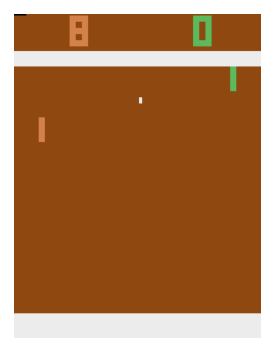

In [11]:
#model2 = pickle.load(open('save_tr.p', 'rb'))
#env = gym.make("Pong-v0")
play_game(env, model)